# `MEI`: Encoding model
Here we adapt an encoding model to the MEI dataset

In [2]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import pandas as pd
import json
from scipy.stats import zscore

### Semantic encoding model
GloVe ([Pennington et al., 2014](http://dx.doi.org/10.3115/v1/D14-1162])) represents each word in a 300-dimensional semantic space where words that are nearer in space are more semantically similar based on co-occurrence statistics from a large corpus of text. We start with a time-stamped stimulus transcript. For each TR, we identify which words occurred in that TR, then assign that TR the semantic embeddings associated with each word. For TRs with multiple words, we average the semantic embeddings; for TRs with no words, we use a 300-dimensional vector of zeros; we exclude a small number of stop words. Finally, to account for the hemodynamic lag in fMRI, we create lagged versions of the embeddings.

In [7]:
# Load in time-stamped transcript
transcript_fn = 'shrek_transcript_final.csv'
transcript = pd.read_csv(transcript_fn, sep=',')

# Stimulus is roughly 800 seconds long
tr = 1.5
stim_dur = 134
stim_trs = int(np.ceil(134 / tr))

# Convert transcript to list for simplicity
transcript = transcript.values.tolist()

# Loop through TRs
transcript_trs = []

In [8]:
# Loop through TRs
for t in np.arange(stim_trs):

    # Container for words in this TR
    tr_words = []

    try:
        # Check if upcoming word onset is in this TR
        while t * tr < transcript[0][2] <= t * tr + tr:
            #print(transcript)

            # If so, pop this word out of list and keep it
            w = transcript.pop(0)
            tr_words.append(w[0])
    except:
        transcript_trs.append(tr_words)
        
        continue


    # Append words and move to the next TR
    transcript_trs.append(tr_words)

In [11]:
transcript_trs[5:10]

[['okay', 'let', 'me', 'get', 'this', 'straight', 'you'],
 ['want', 'to', 'go', 'fight', 'a', 'dragon', 'and'],
 ['rescue', 'a', 'princess', 'just', 'so', 'farquad'],
 ['will', 'give', 'you', 'back', 'a', 'swamp', 'which', 'you'],
 ['only', "don't", 'have', 'cuz', 'he', 'filled', 'it']]

## Get glove embeddings for target movie

Use the get_embeddings.ipynb script to produce the shrek_embeddings json

In [17]:
# Load in dictionary of GloVe embeddings
with open('shrek_embeddings.json') as f:
    glove = json.load(f)
    
# Load list of standard stop words
stopwords = np.load('nltk_stopwords.npy')
append = ["farquad", "there's", "let's", "I", "I'm"]
stopwords = np.append(stopwords, append)

Now that we have a transcript, a dictionary of word embeddings, and a list of stop words, we're ready to construct our predictor matrix. For each TR, obtain the words from `transcript_trs`. If a word is in our list of stop words, ignore it; otherwise, obtain the GloVe embedding for that word. If there are multiple words in a TR (excluding stop words), average their word embeddings to obtain a single embedding per TR. If a TR is empty (i.e. contains no words), set the embedding to a zero vector of the same dimensionality as the other embeddings. Lastly, visualize the resulting predictor matrix; z-score each column (i.e. GloVe dimension) for visualization.

In [22]:
# Assign GloVe embeddings to each TR:
glove_dim = 300

embeddings = []
for t in transcript_trs:
    embeddings_tr = []
    
    # Grab the embedding for each word in a TR
    for w in t:
        
        # Ignore stop words
        if w not in stopwords:
            embeddings_tr.append(np.array(glove[w]).astype(float))
        
    # For non-empty TRs, average the embeddings
    if len(embeddings_tr) > 0:
        embeddings_tr = np.mean(embeddings_tr, axis=0)
    else:
        embeddings_tr = np.zeros(glove_dim)
    embeddings.append(embeddings_tr)

embeddings = np.stack(embeddings, axis=0)

In [23]:
embeddings.shape

(90, 300)

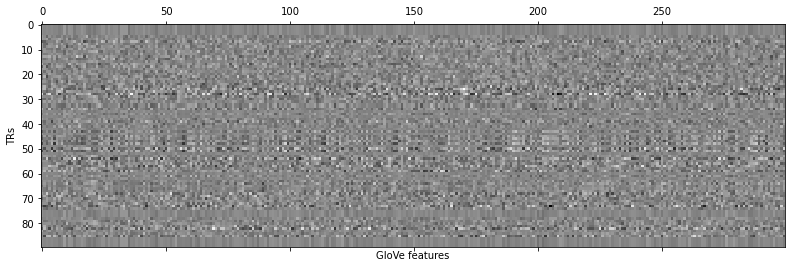

In [24]:
# Visualize predictor matrix of GloVe embeddings:
plt.matshow(zscore(embeddings, axis=0), cmap='binary_r')
plt.xlabel('GloVe features')
plt.ylabel('TRs');

Now, we'll horizontally stack the predictor matrix at lags of 2, 3, 4, and 5 TRs (3, 4.5, 6, 7.5 seconds) to account for variability in hemodynamic lag. Here's one recipe to do this: For each lag, first create prepending zero vectors for each TR in the lag; next, create appending zero vectors corresponding to the difference between the longest lag and the current lag; then, concatenate the prepending and appending vectors at the beginning and end of the predictor matrix, respectively. Horizontally stack the lagged matrices, z-score each column in the lagged predictor matrix, and visualize the matrix.

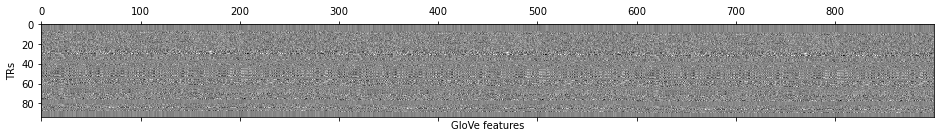

In [25]:
# Create temporally delayed version of embeddings:
lags = [2, 3, 4]

embeddings_lag = []
for lag in lags:
    prepend = np.zeros((lag, glove_dim))
    append = np.zeros((lags[-1] - lag, glove_dim))
    lagged = np.vstack((prepend, embeddings, append))
    embeddings_lag.append(lagged)

# Horizontally stack lagged embeddings:
embeddings_lag = np.hstack(embeddings_lag)

# Z-score embeddings:
from scipy.stats import zscore
embeddings_lag = zscore(embeddings_lag, axis=0)

# Plot lagged predictor matrix:
plt.matshow(embeddings_lag, cmap='binary_r')
plt.xlabel('GloVe features')
plt.ylabel('TRs');

In [26]:
embeddings_lag.shape

(94, 900)

## GET FMRI DATA

Use encoding-fmri.ipynb to load fMRI data for target condition

In [31]:
name = 'shrek_fMRI.npy' #'shrek_fMRI.npy'shrek_ext_07.npy
mov_fMRI = np.load(name, allow_pickle = True)

In [32]:
mov_fMRI.shape # want equal to embeddings shape

(90, 400)

## trim behav

trimming embeddings to match mri data

In [35]:
print('shape of emb', embeddings.shape, 'shape of lag', embeddings_lag.shape)

shape of emb (90, 300) shape of lag (94, 900)


In [36]:
# how many to trim?
start_trs = 4
# trim!
trim_emb = embeddings_lag[start_trs:,:]
print('trim_emb:', trim_emb.shape)

trim_emb: (90, 900)


### Ridge regression
Next, we use ridge regression to predict the activity at each parcel from the semantic embeddings. Note that the model dimensionality ($300 * 4$ delays $= 1200$ dimensions) is much greater than the number of samples ($<550$ TRs). This means we'll need to impose strong regularization on the model. Use a split-half outer cross-validation scheme where we train the model on half of the story and test the model on the other half. To search for the best-performing regularization parameter, perform 5-fold inner cross-validation within each training set using `RidgeCV`; this will select the best parameter setting from the inner cross-validation fold within the training half to predict the test half.

In [41]:
# Ridge regression with alpha grid and nested CV:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from scipy.stats import pearsonr

In [33]:
func_parcels = mov_fMRI

In [37]:
# Split-half outer cross-validation fold:
outer_cv = KFold(n_splits=2) # splits into testing & training halves
inner_cv = KFold(n_splits=5) # splits training half into 5 sections


alphas = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
ridge = RidgeCV(alphas=alphas, cv=inner_cv, scoring='r2')

# Loop through outer split-half cross-validation:
func_predicted = []
for train, test in outer_cv.split(func_parcels): 
    
    # Fit ridge regression with grid search (fit training model)
    ridge.fit(trim_emb[train],
              func_parcels[train]) 
    
    # Compute predicted response
    predicted = ridge.predict(trim_emb[test])
    func_predicted.append(predicted)
    
# Restack first and second half predictions
func_predicted = np.vstack(func_predicted)


### Load brain atlas for visualization
We will use a corticalcortical parcellation containing 400 parcels from [Schaefer and colleages (2018)](https://doi.org/10.1093/cercor/bhx179) to reduce the computational load. 
 - Load in the functional data and atlas. 

In [3]:
# Filenames for intact notthefall data and Schaefer atlas
func_fn = ('sub-284_task-black_space-MNI152NLin2009cAsym_res-native_desc-clean_bold.nii.gz')
atlas_fn = ('Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2.5mm.nii.gz')

# Load in the Schaefer 400-parcel atlas
atlas_nii = nib.load(atlas_fn)
atlas_img = atlas_nii.get_fdata()

### Evaluating model performance
To evaluate the predictions of our model, we use the model weights estimated from the training data to predict the brain activity from semantic embeddings for the test data. We then assess the similarity between the predicted brain activity and the actual brain activity for the test data. Keeping with conventions in the literature, we use Pearson correlation to assess the match between predicted and actual brain activity (although this is not considered a good scoring metric in machine learning and there are many other options; e.g. $R^2$). For each parcel, compute the Pearson correlation between the actual and predicted test time series. Plot the predicted and actual time series for the superior temporal parcel `196` (z-score the actual and predicted time series for plotting).

In [ ]:
'''
311	17Networks_RH_SalVentAttnB_PFCmp_1	8	34	24
312	17Networks_RH_SalVentAttnB_PFCmp_2	8	18	36

151	17Networks_LH_DefaultA_PFCd_1	-24	28	44
152	17Networks_LH_DefaultA_PFCd_2	-18	36	48
153	17Networks_LH_DefaultA_PFCd_3	-22	20	52

359	17Networks_RH_DefaultA_IPL_1	54	-54	26
360	17Networks_RH_DefaultA_IPL_2	48	-64	42

341	17Networks_RH_ContB_IPL_4	42	-56	48
342	17Networks_RH_ContB_PFCld_1	38	34	38
343	17Networks_RH_ContB_PFCld_2	44	18	44
344	17Networks_RH_ContB_PFCld_3	42	6	50
345	17Networks_RH_ContB_PFCld_4	34	16	56
'''

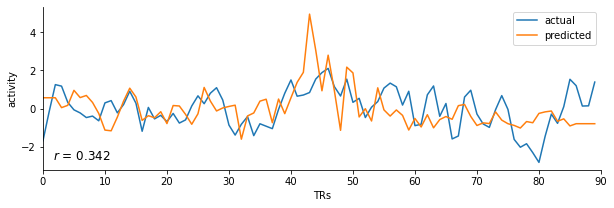

In [36]:
# Compute correlation between predicted and actual responses:
r_parcels = []
for parcel in np.arange(func_parcels.shape[1]):
    r_parcels.append(pearsonr(func_parcels[:, parcel],
                              func_predicted[:, parcel])[0])
    
# Plot predicted and actual response for example parcel:
example_parcel = 369 #### EXAMPLE PARCEL


fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(zscore(func_parcels[:, example_parcel]), label='actual')
ax.plot(zscore(func_predicted[:, example_parcel]), label='predicted')
ax.annotate(f'$\it{{r}}$ = {r_parcels[example_parcel]:.3f}',
            xy=(10, 10), xycoords='axes points', fontsize=12)
ax.set(xlabel='TRs', ylabel='activity', xlim=(0, func_predicted.shape[0]))
ax.legend()
sns.despine()

Finally, we'll plot the prediction performance scores on the brain. Convert the parcel-level prediction scores back into voxel-level brain maps; that is, for every voxel in a given parcel, assign that voxel the parcel's prediction score. Visualize the resulting brain map using `plot_stat_map`.

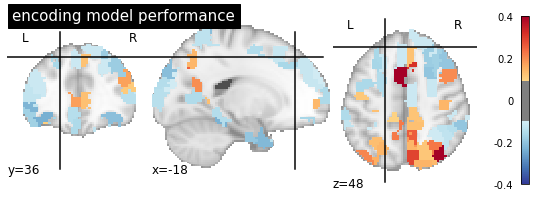

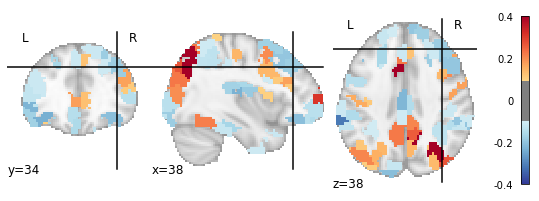

In [57]:
# Plot correlations between actual and predicted responses:
from nilearn.plotting import plot_stat_map

r_img = np.zeros(atlas_img.shape)
for i, parcel in enumerate(np.unique(atlas_img)[1:]):
    r_img[atlas_img == parcel] = r_parcels[i]

# Convert to NIfTI image for visualization with Nilearn
r_nii = nib.Nifti1Image(r_img, atlas_nii.affine, atlas_nii.header)

# Plot correlations to visualize superior temporal cortex
vmax = .4
threshold = .1
plot_stat_map(r_nii, cmap='RdYlBu_r', vmax=vmax, threshold=threshold,
              title='encoding model performance', cut_coords=(-18, 36, 48)) #cut_coords=(-55, -24, 9)(5, 41, -11)

# Plot correlations to visualize posterior medial cortex
plot_stat_map(r_nii, cmap='RdYlBu_r', vmax=vmax, threshold=threshold,
              cut_coords=(38, 34, 38)); #(8, 18, 36) TPJ(48, -64, 42)

# All subjects 

### Load

In [38]:
## get data from enconding_fMRI script ## 
external = np.load("externalR1_data.npy", allow_pickle = True).item()
external[0].shape

(90, 400)

In [43]:
all_subjects = []

In [ ]:
for subject in range(0, 19):
    func_parcels = external[subject]
    print(f'processibg sub {subject}')
    
    outer_cv = KFold(n_splits=2) # splits into testing & training halves
    inner_cv = KFold(n_splits=2) # splits training half into 2 sections

    alphas = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0] # trying to find the best hyperparameter alpha to max predictability
    ridge = RidgeCV(alphas=alphas, cv=inner_cv, scoring='r2') # optimizing the predictors 

    # Loop through outer split-half cross-validation:
    func_predicted = []
    for train, test in outer_cv.split(func_parcels): 

        # Fit ridge regression with grid search (fit training model)
        ridge.fit(trim_emb[train],
                  func_parcels[train]) 

        # Compute predicted response
        predicted = ridge.predict(trim_emb[test]) # using trained model on embeddings of test data set (2nd half)
        func_predicted.append(predicted) # storing predicted activation values

    # Restack first and second half predictions
    func_predicted = np.vstack(func_predicted)
    
    # Compute correlation between predicted and actual responses:
    r_parcels = []
    for parcel in np.arange(func_parcels.shape[1]):
        r_parcels.append(pearsonr(func_parcels[:, parcel],
                                  func_predicted[:, parcel])[0])
        
    all_subjects.append(r_parcels)

In [ ]:
matrix_data = np.array(all_subjects)
matrix_data.shape

In [ ]:
average_across_subjects = np.mean(matrix_data, axis=0)
average_across_subjects.shape

In [ ]:
# Plot correlations between actual and predicted responses:
from nilearn.plotting import plot_stat_map

r_img = np.zeros(atlas_img.shape)
for i, parcel in enumerate(np.unique(atlas_img)[1:]):
    r_img[atlas_img == parcel] = average_across_subjects[i]

# Convert to NIfTI image for visualization with Nilearn
r_nii = nib.Nifti1Image(r_img, atlas_nii.affine, atlas_nii.header)

# Plot correlations to visualize superior temporal cortex
vmax = .4
threshold = .1
plot_stat_map(r_nii, cmap='RdYlBu_r', vmax=vmax, threshold=threshold,
              title='encoding model performance', cut_coords=(-55, -24, 9))

# Plot correlations to visualize posterior medial cortex
plot_stat_map(r_nii, cmap='RdYlBu_r', vmax=vmax, threshold=threshold,
              cut_coords=(-5, -60, 30));

#### References

* Huth, A. G., De Heer, W. A., Griffiths, T. L., Theunissen, F. E., & Gallant, J. L. (2016). Natural speech reveals the semantic maps that tile human cerebral cortex. *Nature*, *532*(7600), 453-458. https://doi.org/10.1038/nature17637

* Nastase, S. A., Liu, Y.-F., Hillman, H., Zadbood, A., Hasenfratz, L., Keshavarzian, N., Chen, J., Honey, C. J., Yeshurun, Y., Regev, M., Nguyen, M., Chang, C. H. C., Baldassano, C., Lositsky, O., Simony, E., Chow, M. A., Leong, Y. C., Brooks, P. P., Micciche, E., Choe, G., Goldstein, A., Vanderwal, T., Halchenko, Y. O., Norman, K. A., & Hasson, U. (2020). Narratives: fMRI data for evaluating models of naturalistic language comprehension. *bioRxiv*. https://doi.org/10.1101/2020.12.23.424091

* Pennington, J., Socher, R., & Manning, C. D. (2014, October). GloVe: Global Vectors for Word Representation. In *Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP)* (pp. 1532-1543). https://www.aclweb.org/anthology/D14-1162

* Schaefer, A., Kong, R., Gordon, E. M., Laumann, T. O., Zuo, X. N., Holmes, A. J., ... & Yeo, B. T. (2018). Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity MRI. Cerebral cortex, 28(9), 3095-3114. https://doi.org/10.1093/cercor/bhx179